In [1]:
#hide
#default_exp models
from nbdev.showdoc import *

# Context Maintenance and Retrieval within an Instance-Based Architecture

Our instance-based implementation of the context maintenance and
retrieval model (InstanceCMR) is a synthesis of two different frameworks
for thinking about episodic memory. The first is the instance-based
MINERVA 2 simulation model. While the classic specification of the
context maintenance and retrieval (CMR) model performs *abstraction at
encoding*, with experiences being integrated into a singular abstractive
representation when it is initially processed, MINERVA 2 model has been
characterized as performing *abstraction at retrieval* because of the
way generalization over experiences occurs only upon processing of some
recall cue. Like MINERVA 2, the model assumes: (1) that only episodic
traces are stored in memory, (2) that repetition produces multiple
traces of an item, (3) that a retrieval cue contacts all memory traces
simultaneously, (4) that each trace is activated according to its
similarity to the retrieval cue, and (5) that all traces respond in
parallel, the retrieved information reflecting their summed output.
InstanceCMR maintains this basic architecture but integrates it with
components of the CMR model. According to the model, representations of
studied items in a free recall experiment are associated with an
internal representation of context that changes slowly during the study
period. These associations in turn account for organizational effects in
recall sequences, such as the tendency for related items to be recalled
successively. Table
&nbsp;<a href="#table:instance_cmr_parameters" data-reference-type="ref" data-reference="table:instance_cmr_parameters">1</a>
provides an overview of the parameters and structures that determine
model behavior.

| Structure Type        | Symbol            | Name                    | Description                                                 |
|:----------------------|:------------------|:------------------------|:------------------------------------------------------------|
| Architecture          |                   |                         |                                                             |
|                       | $M$               | memory                  | Array of accumulated memory traces                          |
|                       | $C$               | temporal context        | A recency-weighted average of encoded items                 |
|                       | $F$               | item features           | Current pattern of item feature unit activations            |
| Context Updating      |                   |                         |                                                             |
|                       | ${\beta}_{enc}$   | encoding drift rate     | Rate of context drift during item encoding                  |
|                       | ${\beta}_{start}$ | start drift rate        | Amount of start-list context retrieved at start of recall   |
|                       | ${\beta}_{rec}$   | recall drift rate       | Rate of context drift during recall                         |
| Associative Structure |                   |                         |                                                             |
|                       | ${\alpha}$        | shared support          | Amount of support items initially have for one another      |
|                       | ${\delta}$        | item support            | Initial pre-experimental contextual self-associations       |
|                       | ${\gamma}$        | learning rate           | Amount of experimental context retrieved by a recalled item |
|                       | ${\phi}_{s}$      | primacy scale           | Scaling of primacy gradient on trace activations            |
|                       | ${\phi}_{d}$      | primacy decay           | Rate of decay of primacy gradient                           |
| Retrieval Dynamics    |                   |                         |                                                             |
|                       | ${\tau}$          | choice sensitivity      | Exponential weighting of similarity-driven activation       |
|                       | ${\theta}_{s}$    | stop probability scale  | Scaling of the stop probability over output position        |
|                       | ${\theta}_{r}$    | stop probability growth | Rate of increase in stop probability over output position   |
|                       |                   |                         |                                                             |

Parameters and structures specifying InstanceCMR

In [2]:
#hide
#export
import math
import numpy as np
from numba import float64, int32, boolean
from numba.experimental import jitclass

spec = [
    ('item_count', int32), 
    ('encoding_drift_rate', float64),
    ('start_drift_rate', float64),
    ('recall_drift_rate', float64),
    ('shared_support', float64),
    ('item_support', float64),
    ('learning_rate', float64),
    ('primacy_scale', float64),
    ('primacy_decay', float64),
    ('stop_probability_scale', float64),
    ('stop_probability_growth', float64),
    ('choice_sensitivity', float64),
    ('context_sensitivity', float64),
    ('feature_sensitivity', float64),
    ('context', float64[::1]),
    ('preretrieval_context', float64[::1]),
    ('recall', float64[::1]),
    ('retrieving', boolean),
    ('recall_total', int32),
    ('item_weighting', float64[::1]),
    ('context_weighting', float64[::1]),
    ('all_weighting', float64[::1]),
    ('probabilities', float64[::1]),
    ('memory', float64[:,::1]),
    ('encoding_index', int32),
    ('items', float64[:,::1])
]

@jitclass(spec)
class InstanceCMR:
    """
    An instance-based implementation of the context maintenance and retrieval (CMR) model.
    """

    def __init__(self, item_count, presentation_count, encoding_drift_rate, start_drift_rate, recall_drift_rate, shared_support,
                 item_support, learning_rate, primacy_scale, primacy_decay, stop_probability_scale,
                 stop_probability_growth, choice_sensitivity, context_sensitivity, feature_sensitivity):
        """
        Initializes model instance with the specified parameter configuration.
        """

        # store initial parameters
        self.item_count = item_count
        self.encoding_drift_rate = encoding_drift_rate
        self.start_drift_rate = start_drift_rate
        self.recall_drift_rate = recall_drift_rate
        self.shared_support = shared_support
        self.item_support = item_support
        self.learning_rate = learning_rate
        self.primacy_scale = primacy_scale
        self.primacy_decay = primacy_decay
        self.stop_probability_scale = stop_probability_scale
        self.stop_probability_growth = stop_probability_growth
        self.choice_sensitivity = choice_sensitivity
        self.context_sensitivity = context_sensitivity
        self.feature_sensitivity = feature_sensitivity
        
        # at the start of the list context is initialized with a state orthogonal to the pre-experimental context
        # associated with the set of items
        self.context = np.zeros(item_count + 1)
        self.context[0] = 1
        self.preretrieval_context = self.context
        self.recall = np.zeros(item_count) # recalls has at most `item_count` entries
        self.retrieving = False
        self.recall_total = 0

        # predefine activation weighting vectors
        self.item_weighting, self.context_weighting = np.ones(item_count+presentation_count), np.ones(item_count+presentation_count)
        self.item_weighting[item_count:] = learning_rate
        self.context_weighting[item_count:] = \
            primacy_scale * np.exp(-primacy_decay * np.arange(presentation_count)) + 1
        self.all_weighting = self.item_weighting * self.context_weighting

        # preallocate for outcome_probabilities
        self.probabilities = np.zeros((item_count + 1))

        # initialize memory
        # we now conceptualize it as a pairing of two stores Mfc and Mcf representing feature-to-context and
        # context-to-feature associations, respectively
        mfc = np.eye(item_count, item_count + 1, 1) * (1 - learning_rate)
        mcf = np.ones((item_count, item_count)) * shared_support
        for i in range(item_count):
            mcf[i, i] = item_support
        mcf = np.hstack((np.zeros((item_count, 1)), mcf))
        self.memory = np.zeros((item_count + presentation_count, item_count * 2 + 2))
        self.memory[:item_count,] = np.hstack((mfc, mcf))
        self.encoding_index = item_count
        self.items = np.eye(item_count, item_count + 1, 1)

    def experience(self, experiences):
        """
        Adds new traces to model memory for each experience based on model state.
        """

        for i in range(len(experiences)):
            self.memory[self.encoding_index, :self.item_count+1] = experiences[i]
            self.update_context(self.encoding_drift_rate, self.memory[self.encoding_index])
            self.memory[self.encoding_index, self.item_count+1:] = self.context
            self.encoding_index += 1

    def update_context(self, drift_rate, experience=None):
        """
        Updates context based on drift rate and either initial context or specified experience.
        """

        # first pre-experimental or initial context is retrieved
        if experience is not None:
            context_input = self.echo(experience)[self.item_count + 1:]
            context_input = context_input / np.sqrt(np.sum(np.square(context_input))) # norm to length 1
        else:
            context_input = np.zeros((self.item_count+1))
            context_input[0] = 1

        # updated context is sum of context and input, modulated by rho to have len 1 and some drift_rate
        rho = np.sqrt(1 + np.square(drift_rate) * (np.square(self.context * context_input) - 1)) - (
                drift_rate * (self.context * context_input))
        self.context = (rho * self.context) + (drift_rate * context_input)

    def echo(self, probe):
        """
        A probe activates all traces in memory in parallel. The sum of these traces weighted by their
        activation is an `echo` summarizing the memory system's response to the probe.
        """
        return np.dot(self.activations(probe), self.memory[:self.encoding_index])

    def activations(self, probe):
        """
        Presents a cue to memory system, activating all traces in memory in parallel. Each trace's
        `activation` is a cubed function of its `similarity` to the probe, weighted based on item position and
        whether probe contains contextual or item features.
        """

        # computes and cubes similarity value to find activation for each trace in memory
        activation = np.dot(self.memory[:self.encoding_index], probe) / (
            np.sqrt(np.sum(np.square(self.memory[:self.encoding_index]), axis=1)) * np.sqrt(
                np.sum(np.square(probe))))

        # weight activations based on whether probe contains item or contextual features or both
        if np.any(probe[:self.item_count + 1]):
                if np.any(probe[self.item_count + 1:]):
                    # both mfc and mcf weightings, see below
                    activation *= self.all_weighting[:self.encoding_index]
                else:
                    # mfc weightings - scale by gamma for each experimental trace
                    activation *= self.item_weighting[:self.encoding_index]
            activation = np.power(activation, self.context_sensitivity)
        else:
            # mcf weightings - scale by primacy/attention function given position of experimental experiences
            activation *= self.context_weighting[:self.encoding_index]
            activation = np.power(activation, self.feature_sensitivity)
            
        return activation + 10e-7

    def outcome_probabilities(self, activation_cue):
        """
        Computes current item recall probabilities given model state and any specified activation patterkml,0on/cue.
        """

        echo = self.echo(activation_cue)[1:self.item_count+1]
        echo = np.power(echo, self.choice_sensitivity)
        
        self.probabilities = np.zeros((self.item_count + 1))
        self.probabilities[0] = min(self.stop_probability_scale * np.exp(
            self.recall_total * self.stop_probability_growth), 1.0 - (self.item_count * 10e-7))

        if self.probabilities[0] < 1:
            for already_recalled_item in self.recall[:self.recall_total]:
                echo[int(already_recalled_item)] = 0
        self.probabilities[1:] = (1-self.probabilities[0]) * echo / np.sum(echo)
        
        return self.probabilities

    def free_recall(self, steps=None):
        """
        Simulates free recall for the specified number of steps based on model state.
        """

        # some pre-list context is reinstated before initiating recall
        if not self.retrieving:
            self.recall = np.zeros(self.item_count)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate)
            self.retrieving = True
            
        # number of items to retrieve is infinite if steps is unspecified
        if steps is None:
            steps = self.item_count - self.recall_total
        steps = self.recall_total + steps

        # at each recall attempt
        while self.recall_total < steps:

            # the current state of context is used as a retrieval cue to 
            # attempt recall of a studied item compute outcome probabilities 
            # and make choice based on distribution
            outcome_probabilities = self.outcome_probabilities(
                np.hstack((np.zeros(self.item_count + 1), self.context)))
            if np.any(outcome_probabilities[1:]):
                choice = np.sum(
                    np.cumsum(outcome_probabilities) < np.random.rand())
            else:
                choice = 0

            # resolve and maybe store outcome
            # we stop recall if no choice is made (0)
            if choice == 0:
                self.retrieving = False
                self.context = self.preretrieval_context
                break
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(self.recall_drift_rate,
                                np.hstack((self.items[choice - 1], 
                                           np.zeros(self.item_count + 1))))
        return self.recall[:self.recall_total]
    
    def force_recall(self, choice=None):
        """
        Forces model to recall chosen item and update context regardless of 
        current model state.

        Here, recall items are 1-indexed, with a choice of 0 indicating a 
        choice to end retrieval and return to preretrieval context.
        """
        if not self.retrieving:
            self.recall = np.zeros(self.item_count)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate)
            self.retrieving = True

        if choice is None:
            pass
        elif choice > 0:
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(
                self.recall_drift_rate, 
                np.hstack((self.items[choice - 1], 
                           np.zeros(self.item_count + 1))))
        else:
            self.retrieving = False
            self.context = self.preretrieval_context
        return self.recall[:self.recall_total]
    
    def compare_probes(self, first_probe, second_probe):
        """
        Compute the resemblance (cosine similarity) between the echoes 
        associated with first_probe and second_probe.
        """
        echoes = self.echo(first_probe), self.echo(second_probe)
        return np.sum(echoes[0] * echoes[1]) / (
            np.sqrt(np.sum(np.square(echoes[0]))) * np.sqrt(np.sum(np.square(echoes[1]))))

In [3]:

try:
    show_doc(InstanceCMR, doc_string=False)
except:
    pass

<h2 id="InstanceCMR" class="doc_header"><code>class</code> <code>InstanceCMR</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>InstanceCMR</code>(**\*`args`**, **\*\*`kwargs`**) :: [`InstanceCMR`](/instance_cmr/InstanceCMR.html#InstanceCMR)



In InstanceCMR, units with activity patterns representing features of
studied items $F$ and units representing current temporal context $C$
interact over the course of a list-learning experiment. Item
representations are assumed to be orthonormal to each other: each unit
of $F$ corresponds to support for one particular item. Corresponding
units of the model&rsquo;s context representation $C$ similarly
represent support for each item, but additional units enable context to
be set orthogonal to possible item representations as well. The two
representations communicate with one another by being stored and
retrieved together as memory traces in a global memory model, i.e. as a
concatenated vector. When an item is presented during a list-learning
experiment, it&rsquo;s assumed that the activated representation is a
concatenation of the item&rsquo;s features $f_i$ and the temporal
context of its presentation $c_i$. Memory for each experience is in turn
encoded as a separate row in an $m$ by $n$ memory matrix $M$ where rows
correspond to memory traces and columns correspond to features,

$$\label{equation:architecture} 
    M_i = (f_i, c_i)$$

## Initialization

In [4]:

try:
    show_doc(InstanceCMR.__init__, doc_string=False)
except:
    pass

<h4 id="InstanceCMR.__init__" class="doc_header"><code>InstanceCMR.__init__</code><a href="__main__.py#L76" class="source_link" style="float:right">[source]</a></h4>

> <code>InstanceCMR.__init__</code>(**`item_count`**, **`presentation_count`**, **`encoding_drift_rate`**, **`start_drift_rate`**, **`recall_drift_rate`**, **`shared_support`**, **`item_support`**, **`learning_rate`**, **`primacy_scale`**, **`primacy_decay`**, **`stop_probability_scale`**, **`stop_probability_growth`**, **`choice_sensitivity`**)



The content of memory traces are instantiated differently depending on
whether representations reflect pre-experimental associations created at
model instantiation or new associations learned during encoding. To set
pre-experimental associations, a trace is encoded into memory for each
relevant item. Each entry $j$ for each pre-experimental feature vector
$f_i$ is set according to

$$f_{pre(ij)} = \begin{cases} \begin{alignedat}{2} 1 - \gamma \text{, if } i=j \\
          0 \text{, if } i \neq j\\
       \end{alignedat} \end{cases}$$

This has the effect of connecting each index on $F$ to the corresponding
index on $C$ during retrieval from a partial or mixed cue. The $\gamma$
parameter controls the strength of these pre-experimental associations
relative to experimental associations.

Similarly to control pre-experimental context-to-item associations,
entries for each pre-experimental context vector $c_i$ are set according
to:

$$c_{pre(ij)} = \begin{cases} \begin{alignedat}{2} \delta \text{, if } i=j \\
          \alpha \text{, if } i \neq j\\
       \end{alignedat} \end{cases}$$

Here, $\delta$ works similarly to $\gamma$ to connect indices on $C$ to
the corresponding index on $F$ during retrieval from a partial or mixed
cue. The $\alpha$ parameter alternatively allows all the items to
support one another in the recall competition in a uniform manner.

Before list-learning, context $C$ is initialized with a state orthogonal
to the pre-experimental context associated with the set of items via the
extra index that the representation vector has relative to items&rsquo;
feature vectors.

## Memory Access

In [ ]:
try:
    show_doc(InstanceCMR.activations, doc_string=False)
    show_doc(InstanceCMR.echo, doc_string=False)
except:
    pass

The contextual representation associated with a given feature
representation can be retrieved by presenting a partial probe to memory
(e.g. a vector with feature information but no contextual information:
$(f_i, 0)$). Retrieval proceeds according to a two-step process. In the
activation step $A$, the probe $p$ activates all traces in memory $M$ in
parallel. Each trace&rsquo;s activation is computed as an exponent of
its cosine similarity to the probe.

$$a_i = \left({\frac {\sum^{j=n}_{j=1}{p_j \times M_{ij}}} {\sqrt{\sum^{j=n}_{j=1}{p^2_j}}
        \sqrt{\sum^{j=n}_{j=1}{M^2_{ij}}}}}\right)^{\tau}$$

where $a_i$ is the activation of trace $i$ in memory, $p_j$ is the value
of feature $j$ in the probe, $M_{ij}$ is the value if feature $j$ of
trace $i$ in memory, $n$ is the number of columns in memory, and $\tau$
is a sensitivity parameter that determines the contrast between
well-supported and poorly-supported traces. To avoid the possibility of
assigning a probability of 0 to any possible recall, we set a minimal
activation for each item to $10^{-7}$.

To account for differences between pre-experimental and experimental
associations as constraints on behavior, activation is further modulated
depending on the structure of the probe. When there is item feature
information in the probe ($p_f \neq 0$), activation for traces encoded
during the experiment $a_{exp}$ are modulated by $\gamma$

$$a_{exp(i)} = \gamma \cdot \left({\frac {\sum^{j=n}_{j=1}{p_j \times M_{ij}}} {\sqrt{\sum^{j=n}_{j=1}{p^2_j}}
        \sqrt{\sum^{j=n}_{j=1}{M^2_{ij}}}}}\right)^{\tau} \text{ if } p_f \neq 0$$

Similarly, when there is contextual information in the probe
($p_c \neq 0$), activation for traces encoded during the experiment are
modulated by $\phi$

$$a_{exp(i)} = \phi_i \cdot \left({\frac {\sum^{j=n}_{j=1}{p_j \times M_{ij}}} {\sqrt{\sum^{j=n}_{j=1}{p^2_j}}
        \sqrt{\sum^{j=n}_{j=1}{M^2_{ij}}}}}\right)^{\tau} \text{ if } p_c \neq 0$$

where $phi_i$ scales the amount of learning, simulating increased
attention to initial items in a list that has been proposed to explain
the primacy effect. $phi_i$ depends on the serial position $i$ of the
studied item:

$$phi_i = phi_se^{-phi_d(i-1)} + 1$$

The free parameters $phi_s$ and $phi_d$ control the magnitude and decay
of this learning-rate gradient, respectively.

In the echo step $E$, a weighted sum of the traces - called an echo - is
retrieved where each trace is weighted by its corresponding activation.

$$e_j = \sum^{i=m}_{i=1}\sum^{j=n}_{j=1}a_i \times M_{ij}$$

where $e_j$ is feature $j$ in the echo, $m$ is the number of traces in
memory, $a_i$ is the activation of trace $i$, and $M_{ij}$ is the value
of feature $j$ in trace $i$ in memory.

While a partial probe may exclude contextual information (or vice
versa), traces containing contextual information are still activated
based on the content of the included feature information. The retrieved
echo thus contains a representation of the contextual information
associated with the probe feature vector $f_i$.

## Encoding Items

In [ ]:
try:
    show_doc(InstanceCMR.experience, doc_string=False)
    show_doc(InstanceCMR.update_context, doc_string=False)
except:
    pass

When an item $i$ is presented during the study period, its
representation on $F$, $f_i$, is activated. Pre-experimental context
$c_{i}^{IN}$ is retrieved using the two-step echo $E$ mechanism
described below by presenting $(f_i, 0)$ as a probe to memory. The input
to context is retrieved by

$$(\_ , c_{i}^{IN}) = E\left[(f_i, 0)\right]$$

where the contextual features of the retrieved echo determine contextual
input. The retrieved pre-experimental context is then normalized to have
length 1.

After retrieval of pre-experimental context $c_{i}^{IN}$, the current
state of context is updated according to.

$$c_i = \rho_ic_{i-1} + \beta c_{i}^{IN}$$

Where $\beta$ is set to $\beta_{enc}$ and $rho_i$ is set so that the
length of $c_i$ is 1, according to

$$\rho_i = \sqrt{1 + \beta^2\left[\left(c_{i-1} \cdot c^{IN}_i\right)^2 - 1\right]} - \beta\left(c_{i-1} \cdot
c^{IN}_i\right)$$

After context is updated, the current item $f_i$ and the current state
of context $c_i$ become associated in memory $M$ by storing a
concatenation of the two vectors as a new trace according to Equation 1.

## Performing Free Recall

In [ ]:

try:
    show_doc(InstanceCMR.outcome_probabilities, doc_string=False)
    show_doc(InstanceCMR.free_recall, doc_string=False)
except:
    pass

Before initiating recall, we assume that some amount of the pre-list
context is reinstated. We assume that context is updated according to

$$c_{start} = \rho_{N+1}c_N + \beta_{start}c_0$$

where $c_{start}$ is the state of context at the start of free recall,
$N$ is the number of items in the list, $c_0$ is the state of context at
the start of the list before any item presentation, and $\rho_{N+1}$ is
calculated as specified above.

At each recall attempt, the current state of context is used as a
retrieval cue to attempt retrieval of a studied item. First, the
activation of each trace is determined following the trace activation
mechanism specified above:

$$a = A[(0, c)]$$

Also at each recall attempt, we calculated the probability of stopping
recall (where no item was recalled and search terminated). It varies as
a function of output position $j$ (where $j=0$ for the first attempt),
according to

$$P(stop, j) = \theta_se^{j\theta_r}$$

where $\theta_s$ and $\theta_r$ are free parameters that determine the
scaling and rate of increase, respectively, of the exponential function.

The probability $P(i)$ of recalling a given trace $i$ is defined
conditional on recall not stopping at that position, and varies with
activation strength, according to

$$P(i) = (1-P(stop))\frac{a^{\tau}_i}{\sum_{k}^{N}a^{\tau}_k}$$

If a trace is recalled, then the item with the most similar feature
representation is reactivated on $F$. The reactivated item is then used
to retrieve a representation of context according to

$$c_i^{IN} = E[(f_i, 0)]$$

Context is then updated using the mechanism for it specified in the
above section, and is used to cue for another recall attempt. The
process continues until the model reaches the end of the recall
sequence.

## Additional Mechanisms
Additional model mechanisms are included to support model analysis and extension.

In [ ]:

try:
    show_doc(InstanceCMR.force_recall)
    show_doc(InstanceCMR.compare_probes)
except:
    pass

## Supporting Parameter Search

Since our fitting functions are optimized on a per model basis, we need a unique one for InstanceCMR.

In [ ]:
#export
#hide
import numpy as np
from numba import njit
from numba.typed import List

@njit(fastmath=True, nogil=True)
def icmr_likelihood(data_to_fit, item_counts, encoding_drift_rate, 
                    start_drift_rate, recall_drift_rate, shared_support, 
                    item_support, learning_rate, primacy_scale, primacy_decay, 
                    stop_probability_scale, stop_probability_growth, 
                    choice_sensitivity):
    """
    Generalized cost function for fitting the InstanceCMR model optimized 
    using the numba library.
    
    Output scales inversely with the likelihood that the model and specified 
    parameters would generate the specified trials. For model fitting, is 
    usually wrapped in another function that fixes and frees parameters for 
    optimization.

    **Arguments**:
    - data_to_fit: typed list of int64-arrays where rows identify a unique 
        trial of responses and columns corresponds to a unique recall index.  
    - A configuration for each parameter of `InstanceCMR` as delineated in 
        `Formal Specification`.

    **Returns** the negative sum of log-likelihoods across specified trials 
    conditional on the specified parameters and the mechanisms of InstanceCMR.
    """
        
    result = 0.0
    for i in range(len(item_counts)):
        item_count = item_counts[i]
        trials = data_to_fit[i]
        
        model = InstanceCMR(item_count, item_count, encoding_drift_rate, 
                          start_drift_rate, recall_drift_rate, shared_support, 
                          item_support, learning_rate, primacy_scale, 
                          primacy_decay, stop_probability_scale, 
                          stop_probability_growth, choice_sensitivity)

        model.experience(np.eye(item_count, item_count + 1, 1))

        likelihood = np.ones((len(trials), item_count))

        for trial_index in range(len(trials)):
            trial = trials[trial_index]

            model.force_recall()
            for recall_index in range(len(trial) + 1):

                # identify index of item recalled; if zero then recall is over
                if recall_index == len(trial) and len(trial) < item_count:
                    recall = 0
                else:
                    recall = trial[recall_index]

                # store probability of and simulate recalling item w this index
                activation_cue = np.hstack(
                    (np.zeros(model.item_count + 1), model.context))
                likelihood[trial_index, recall_index] = \
                    model.outcome_probabilities(activation_cue)[recall]

                if recall == 0:
                    break
                model.force_recall(recall)

            # reset model to its pre-retrieval (but post-encoding) state
            model.force_recall(0)
        result -= np.sum(np.log(likelihood))
        
    return result

def icmr_objective_function(data_to_fit, fixed_parameters, free_parameters):
    """
    Generates and returns an objective function for input to support search 
    through parameter space for ICMR model fit using an optimization function.

    Arguments:  
    - fixed_parameters: dictionary mapping parameter names to values they'll 
        be fixed to during search, overloaded by free_parameters if overlap  
    - free_parameters: list of strings naming parameters for fit during search  
    - data_to_fit: array where rows identify a unique trial of responses and 
        columns corresponds to a unique recall index

    Returns a function that accepts a vector x specifying arbitrary values for 
    free parameters and returns evaluation of icmr_likelihood using the model 
    class, all parameters, and provided data.
    """
    
    return lambda x: icmr_likelihood(data_to_fit, **{**fixed_parameters, **{
        free_parameters[i]:x[i] for i in range(len(x))}})

In [ ]:
try:
    show_doc(icmr_likelihood, title_level=3)
    show_doc(icmr_objective_function, title_level=3)
except:
    pass

Using these functions, we'll search for and visualize a parameter fit of the InstanceCMR model to a slice of data sampled from the classic Murdock (1962) study demonstrating the serial position curve, a pattern where early and later presented items tend to be recalled more often than middle items in a list-learning experiment. The data associated with the study is located at `data/MurdData_clean.mat`.

In [ ]:
from instance_cmr.model_analysis import *

murd_trials0, murd_events0, murd_length0 = prepare_murddata(
    '../data/MurdData_clean.mat', 0)
print(murd_length0, np.shape(murd_trials0))

murd_trials1, murd_events1, murd_length1 = prepare_murddata(
    '../data/MurdData_clean.mat', 1)
print(murd_length1, np.shape(murd_trials1))

murd_events1.head()

20 (1200, 15)
30 (1200, 15)


,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,NaN,True,False,0,False
1,1,1,2,2,NaN,True,False,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


|    |   subject |   list |   item |   input |   output | study   | recall   |   repeat | intrusion   |
|---:|----------:|-------:|-------:|--------:|---------:|:--------|:---------|---------:|:------------|
|  0 |         1 |      1 |      1 |       1 |        5 | True    | True     |        0 | False       |
|  1 |         1 |      1 |      2 |       2 |        7 | True    | True     |        0 | False       |
|  2 |         1 |      1 |      3 |       3 |      nan | True    | False    |        0 | False       |
|  3 |         1 |      1 |      4 |       4 |      nan | True    | False    |        0 | False       |
|  4 |         1 |      1 |      5 |       5 |      nan | True    | False    |        0 | False       |

First, we'll make sure icmr_likelihood returns valid values and has adequate performance.

In [ ]:

lb = np.finfo(float).eps
hand_fit_parameters = {
    'item_counts': List([murd_length0, murd_length1]),
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}
icmr_likelihood(List([murd_trials0[:80], murd_trials1[:80]]), **hand_fit_parameters)

In [ ]:
%%timeit
icmr_likelihood(List([murd_trials0[:80], murd_trials1[:80]]), **hand_fit_parameters)

We'll fix some hand-selected parameters and search for a configuration of just the encoding_drift_rate` parameter that maximizes the model's fit to the data.

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity']

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = icmr_objective_function(List([murd_trials0[:80], murd_trials1[:80]]), 
                                        {'item_counts': List([murd_length0, murd_length1])}, free_parameters)

result = differential_evolution(cost_function, bounds, disp=True)
print(result)

differential_evolution step 1: f(x)= 6112.95
differential_evolution step 2: f(x)= 4127.12
differential_evolution step 3: f(x)= 3987.31
differential_evolution step 4: f(x)= 3987.31
differential_evolution step 5: f(x)= 3987.31
differential_evolution step 6: f(x)= 3987.31
differential_evolution step 7: f(x)= 3987.31
differential_evolution step 8: f(x)= 3987.31
differential_evolution step 9: f(x)= 3987.31
differential_evolution step 10: f(x)= 3987.31
differential_evolution step 11: f(x)= 3987.31
differential_evolution step 12: f(x)= 3987.31
differential_evolution step 13: f(x)= 3945.85
differential_evolution step 14: f(x)= 3945.85
differential_evolution step 15: f(x)= 3750.06
differential_evolution step 16: f(x)= 3750.06
differential_evolution step 17: f(x)= 3750.06
differential_evolution step 18: f(x)= 3750.06
differential_evolution step 19: f(x)= 3750.06
differential_evolution step 20: f(x)= 3750.06
differential_evolution step 21: f(x)= 3750.06
differential_evolution step 22: f(x)= 3569.

For the first subject in our murd_trials data structure, the function runs quickly returns an output with the following attributes:

```
     fun: 1066.6198672539826
 message: 'Optimization terminated successfully.'
    nfev: 12411
     nit: 74
 success: True
       x: array([7.83057993e-01, 8.43579311e-03, 8.41344768e-01, 5.16132856e-03,
       9.28416235e-01, 1.90157671e-01, 1.00393775e+01, 3.25689988e+01,
       1.17197475e-02, 3.87954549e-01, 1.57952789e+00])
```

The `x` attribute of the result object contains the best parameter configuration found, while the `fun`
attribute represents the overall cost of the configuration as computed with our specified cost function. 

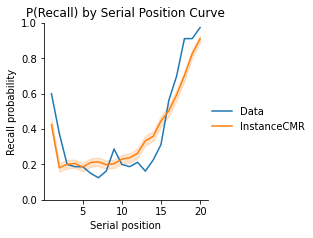

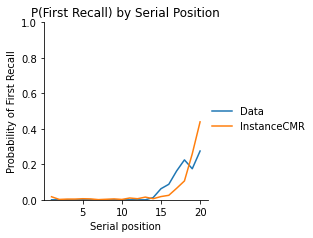

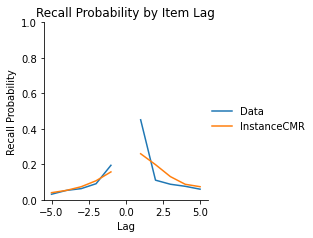

In [ ]:
parameters = {
    'item_count': murd_length0,
    'presentation_count': murd_length0,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

visualize_fit(InstanceCMR, 
              {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
              murd_events0, 'subject == 1', experiment_count=1000, savefig=True)

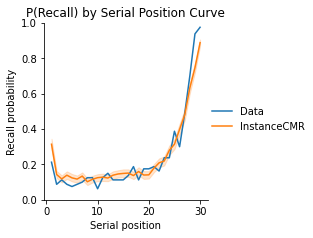

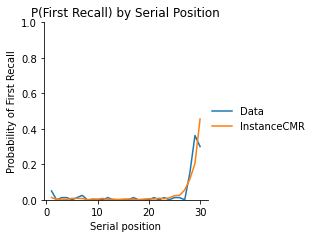

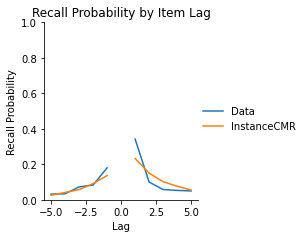

In [ ]:
parameters = {
    'item_count':murd_length1,
    'presentation_count': murd_length1,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

visualize_fit(InstanceCMR, 
              {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
              murd_events1, 'subject == 1', experiment_count=1000, savefig=True)

### Entire Dataset

For the entire 20-item Murd72 dataset, the results were:
```
     fun: 21189.361909423762
     jac: array([  370.85883191,   395.01792365,  -284.3506067 , -4803.43042003,
          54.62388772,   182.5606888 ,   -16.67685875,     0.        ,
       -5460.87867314, -2637.80421076,   -19.46173154])
 message: 'Optimization terminated successfully.'
    nfev: 11199
     nit: 66
 success: True
       x: array([7.46510490e-01, 6.39097142e-02, 8.24181640e-01, 4.02289265e-03,
       5.34680153e-01, 2.72774711e-01, 4.47377578e+00, 4.97277656e+01,
       3.86851140e-02, 2.30541281e-01, 1.53490018e+00])
```

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity']

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = icmr_objective_function(List([murd_trials0, murd_trials1]), 
                                        {'item_counts': List([murd_length0, murd_length1])}, free_parameters)

result = differential_evolution(cost_function, bounds, disp=True)
print(result)

differential_evolution step 1: f(x)= 69043
differential_evolution step 2: f(x)= 69043
differential_evolution step 3: f(x)= 69043
differential_evolution step 4: f(x)= 69043
differential_evolution step 5: f(x)= 63308.8
differential_evolution step 6: f(x)= 63308.8
differential_evolution step 7: f(x)= 63308.8
differential_evolution step 8: f(x)= 63308.8
differential_evolution step 9: f(x)= 63308.8
differential_evolution step 10: f(x)= 63308.8
differential_evolution step 11: f(x)= 63187.1
differential_evolution step 12: f(x)= 63187.1
differential_evolution step 13: f(x)= 63187.1
differential_evolution step 14: f(x)= 63139.8
differential_evolution step 15: f(x)= 62877.6
differential_evolution step 16: f(x)= 62409.3
differential_evolution step 17: f(x)= 62409.3
differential_evolution step 18: f(x)= 61302.6
differential_evolution step 19: f(x)= 61302.6
differential_evolution step 20: f(x)= 61264.5
differential_evolution step 21: f(x)= 57934.3
differential_evolution step 22: f(x)= 57934.3
diffe

C:\Users\gunnj\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


     fun: 50845.0936809554
 message: 'Optimization terminated successfully.'
    nfev: 11916
     nit: 71
 success: True
       x: array([7.05068428e-01, 1.69545358e-02, 7.73285088e-01, 3.30627833e-03,
       3.62254512e-01, 2.57261169e-01, 4.57960201e+00, 3.52306107e+01,
       4.60031508e-02, 1.86046249e-01, 1.71344249e+00])


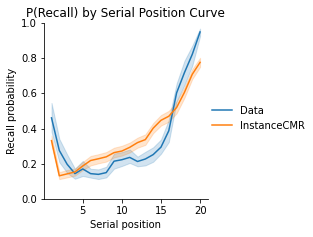

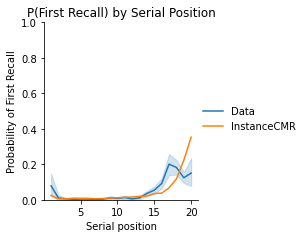

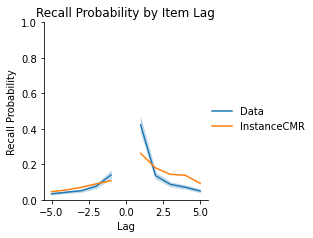

In [ ]:
parameters = {
    'item_count': murd_length0,
    'presentation_count': murd_length0,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

visualize_fit(InstanceCMR, {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
        murd_events0, 'subject > -1', experiment_count=1000, savefig=True)

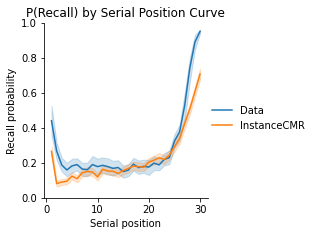

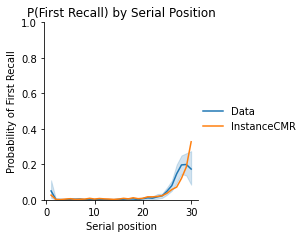

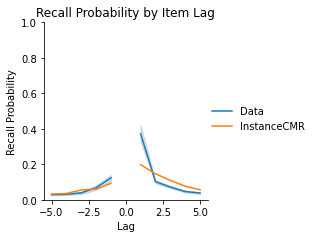

In [ ]:
parameters = {
    'item_count': murd_length1,
    'presentation_count': murd_length1,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

visualize_fit(InstanceCMR, {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
        murd_events1, 'subject > -1', experiment_count=1000, savefig=True)